# 1. Imports und Konfiguration

In [1]:
import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.callbacks import EvalCallback
import os
import matplotlib.pyplot as plt
import numpy as np
from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv

SEED = 42
ENV_ID = "LunarLander-v3"
MODEL_DIR = "models/"
LOG_DIR = "logs/"
VIDEO_DIR = "videos/"

os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(LOG_DIR, exist_ok=True)


# 2. Umgebung erstellen

In [2]:
env = make_vec_env(ENV_ID, n_envs=4, seed=SEED)
eval_env = gym.make(ENV_ID, render_mode="rgb_array")


# 3. Callback zur Evaluierung während des Trainings

In [3]:
eval_callback = EvalCallback(
    eval_env,
    best_model_save_path=MODEL_DIR,
    log_path=LOG_DIR,
    eval_freq=10_000,
    deterministic=True,
    render=False,
)


# 4. Agent (PPO) definieren

In [4]:
model = PPO(
    "MlpPolicy",           # vollverbundenes Netz
    env,
    verbose=1,
    seed=SEED,
    n_steps=2048,
    batch_size=64,
    gamma=0.99,
    gae_lambda=0.95,
    clip_range=0.2,
    ent_coef=0.01,
    tensorboard_log=LOG_DIR,
)


Using cuda device


D:\Users\BKU\luisklenk\AppData(Roaming)\Python\Python312\site-packages\stable_baselines3\common\on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


# 5. Training starten

In [5]:
TOTAL_TIMESTEPS = 500_000
model.learn(total_timesteps=TOTAL_TIMESTEPS, callback=eval_callback)

# Optional: Letztes Modell speichern
model.save(os.path.join(MODEL_DIR, "last_model"))


Logging to logs/PPO_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 93       |
|    ep_rew_mean     | -182     |
| time/              |          |
|    fps             | 1037     |
|    iterations      | 1        |
|    time_elapsed    | 7        |
|    total_timesteps | 8192     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 94.5        |
|    ep_rew_mean          | -158        |
| time/                   |             |
|    fps                  | 656         |
|    iterations           | 2           |
|    time_elapsed         | 24          |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.006867378 |
|    clip_fraction        | 0.0551      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.38       |
|    explained_variance   | 0.000672    |
|    lea

D:\Users\BKU\luisklenk\AppData(Roaming)\Python\Python312\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=40000, episode_reward=-2051.20 +/- 131.33
Episode length: 486.00 +/- 32.02
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 486         |
|    mean_reward          | -2.05e+03   |
| time/                   |             |
|    total_timesteps      | 40000       |
| train/                  |             |
|    approx_kl            | 0.011010952 |
|    clip_fraction        | 0.145       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.29       |
|    explained_variance   | 0.336       |
|    learning_rate        | 0.0003      |
|    loss                 | 77.1        |
|    n_updates            | 40          |
|    policy_gradient_loss | -0.0128     |
|    value_loss           | 235         |
-----------------------------------------
New best mean reward!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 113      |
|    ep_rew_mean     | -90

# 6. Evaluation & Testepisode anzeigen

In [6]:
model = PPO.load(os.path.join(MODEL_DIR, "best_model"), env=eval_env)

obs, _ = eval_env.reset()
done = False
rewards = []

while not done:
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, _ = eval_env.step(action)
    rewards.append(reward)
    done = terminated or truncated

print(f"Return dieser Episode: {sum(rewards):.2f}")


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Return dieser Episode: 248.63


# 7. (Optional) Videoaufzeichnung

In [7]:
video_env = DummyVecEnv([lambda: gym.make(ENV_ID, render_mode="rgb_array")])
video_env = VecVideoRecorder(
    video_env,
    VIDEO_DIR,
    record_video_trigger=lambda x: x == 0,
    video_length=500,
    name_prefix="ppo-lunarlander",
)
video_model = PPO.load(os.path.join(MODEL_DIR, "best_model"))
obs = video_env.reset()

for _ in range(500):
    action, _ = video_model.predict(obs)
    obs, _, done, _ = video_env.step(action)
    if done.any():
        break

video_env.close()


MoviePy - Building video d:\Dev\6.Semester\RL\Abgabe_3\videos\ppo-lunarlander-step-0-to-step-500.mp4.
MoviePy - Writing video d:\Dev\6.Semester\RL\Abgabe_3\videos\ppo-lunarlander-step-0-to-step-500.mp4



MoviePy - Done !
MoviePy - video ready d:\Dev\6.Semester\RL\Abgabe_3\videos\ppo-lunarlander-step-0-to-step-500.mp4


C:\Users\luisklenk\AppData\Local\Temp\ipykernel_30972\3757784532.py:25: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(data=df_rewards, x="Timestep", y="Reward", color="blue", label="Durchschnitt", ci="sd")  # Standardabweichung


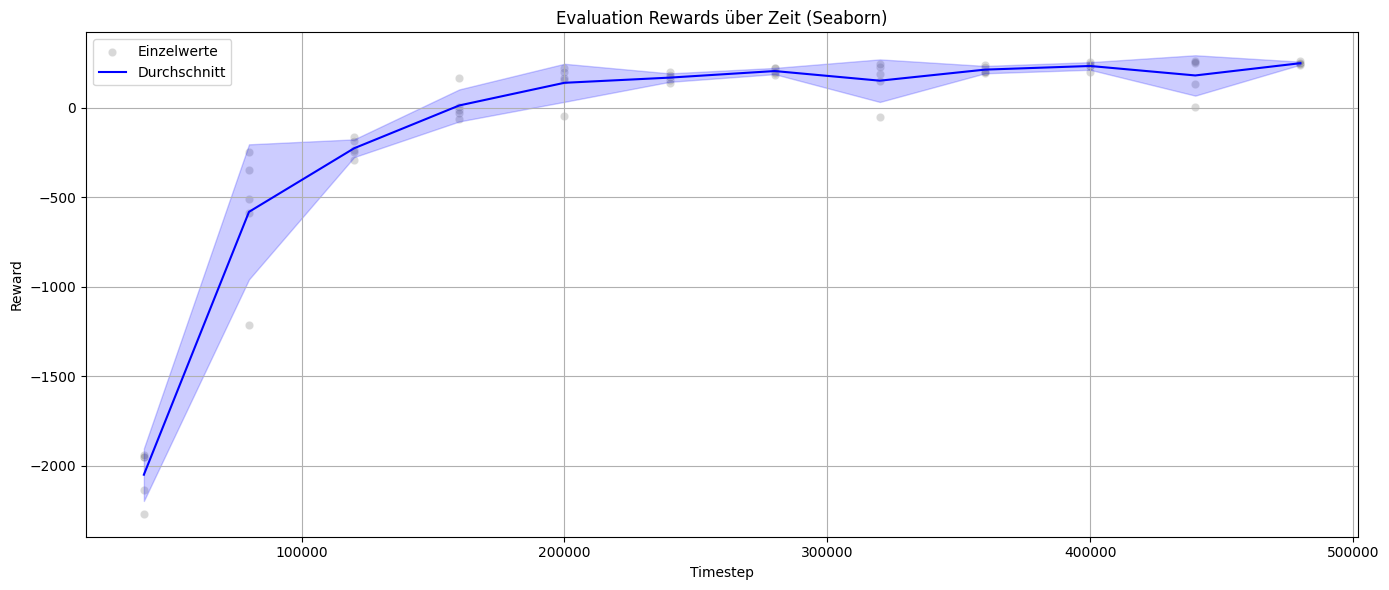

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Pfad zur Logdatei
eval_log_path = os.path.join(LOG_DIR, "evaluations.npz")
data = np.load(eval_log_path)

timesteps = data["timesteps"]
results = data["results"]  # shape: (n_evals, n_eval_episodes)
ep_lengths = data.get("ep_lengths", None)

# --- Daten in DataFrame umwandeln ---
# Jeden einzelnen Reward mit zugehörigem Timestep verbinden
df_rewards = pd.DataFrame({
    "Timestep": np.repeat(timesteps, results.shape[1]),
    "Reward": results.flatten()
})

# --- Plot mit Seaborn ---
plt.figure(figsize=(14, 6))
sns.scatterplot(data=df_rewards, x="Timestep", y="Reward", color="gray", alpha=0.3, label="Einzelwerte")
sns.lineplot(data=df_rewards, x="Timestep", y="Reward", color="blue", label="Durchschnitt", ci="sd")  # Standardabweichung

plt.title("Evaluation Rewards über Zeit (Seaborn)")
plt.xlabel("Timestep")
plt.ylabel("Reward")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("seaborn_reward_timeseries.png")
plt.show()


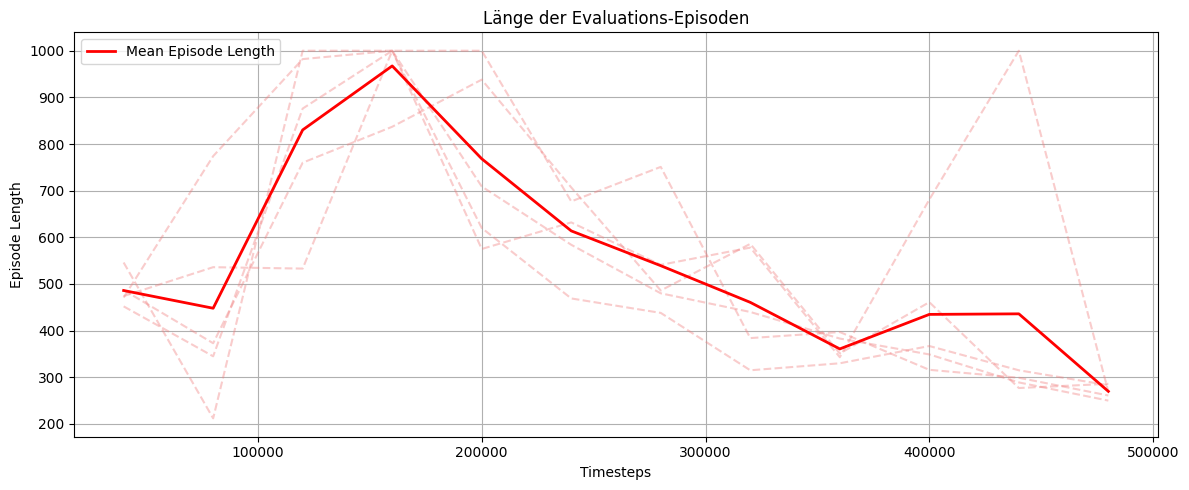

In [9]:
if ep_lengths is not None:
    plt.figure(figsize=(12, 5))

    for i in range(ep_lengths.shape[1]):
        plt.plot(timesteps, ep_lengths[:, i], color="lightcoral", linestyle="--", alpha=0.4, label="_nolegend_")

    mean_lengths = ep_lengths.mean(axis=1)
    plt.plot(timesteps, mean_lengths, color="red", linewidth=2, label="Mean Episode Length")

    plt.xlabel("Timesteps")
    plt.ylabel("Episode Length")
    plt.title("Länge der Evaluations-Episoden")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("episode_length_progress.png")
    plt.show()
